<a href="https://colab.research.google.com/github/Ian-Sinclair/Computer-Vision-Seamless-Panoramic-Image/blob/main/ENCE_4620_Project_4_Ian_Sinclair.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Installs

In [ ]:
!pip install opencv-contrib-python==4.4.0.44

# Imports

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mp
import PIL as pl
from PIL import Image as PL
import cv2 as cv
from statistics import mean
import math

from scipy.spatial import distance as dist

import numpy as np
import argparse
import glob

import argparse
import imutils

from google.colab import drive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Loading Images

In [ ]:

import copy
raw_images = []

image_path = 'drive/MyDrive/DU1[1].JPG'
raw_images.append( mp.imread(image_path) )

image_path = 'drive/MyDrive/DU2[1].JPG'
raw_images.append( mp.imread(image_path) )

image_path = 'drive/MyDrive/DU3[1].JPG'
raw_images.append( mp.imread(image_path) )

test_images = []
for image in raw_images :
  test_images.append( image.copy() )


In [ ]:

import copy
raw_images = []

from PIL import Image as PL

image_path = 'drive/MyDrive/20220308_164247.jpg'
raw_images.append( np.array(PL.open(image_path).rotate(270, expand = True)) )

image_path = 'drive/MyDrive/20220308_164151.jpg'
raw_images.append( np.array(PL.open(image_path).rotate(270, expand = True)) )

image_path = 'drive/MyDrive/20220308_164155.jpg'
raw_images.append( np.array(PL.open(image_path).rotate(270, expand = True)) )


test_images = []
for image in raw_images :
  test_images.append( image.copy() )


In [ ]:
import copy
raw_images = []

image_path = 'drive/MyDrive/nueva-york (4).jpg'
raw_images.append( mp.imread(image_path) )

image_path = 'drive/MyDrive/nueva-york (3).jpg'
raw_images.append( mp.imread(image_path) )

image_path = 'drive/MyDrive/nueva-york (2).jpg'
raw_images.append( mp.imread(image_path) )

test_images = []
for image in raw_images :
  test_images.append( image.copy() )

In [ ]:
Stitched_images = [ test_images[0] ]

Displaying Raw Images

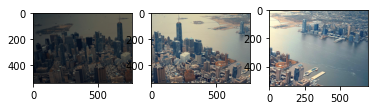

In [ ]:
%matplotlib inline
fig, axs = plt.subplots(1, len( raw_images ))
for i in range( 0 , len( raw_images )) :
  axs[i].imshow( raw_images[i] )

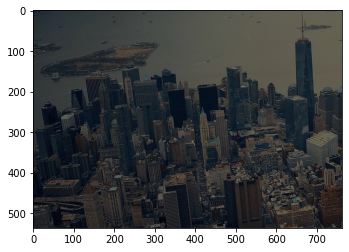

In [ ]:
plt.imshow(raw_images[0])

# SIFT Feature Detection

In [ ]:
def SIFT_detection( imagee ) :
  im = imagee.copy()
  sift = cv.SIFT_create()
  gray = cv.cvtColor(im,cv.COLOR_BGR2GRAY)

  kp,desc = sift.detectAndCompute(gray,None)

  SIFT_Image = cv.drawKeypoints(gray,kp,im)

  return kp, desc, SIFT_Image

If keyPoints are known

In [ ]:
def SIFT_description_detection( image_A, key_pointss ) :
  img = image_A.copy()
  sift = cv.SIFT_create()
  gray = cv.cvtColor(img,cv.COLOR_BGR2GRAY)
  k, desc = sift.compute(gray, key_pointss)

  return k, desc

# Harris corner detector

In [ ]:
def Harris_Corner_Keypoints( imageee, blockSize, kSize, k, keepThreshold ) :
  im = imageee.copy()
  gray = cv.cvtColor(im,cv.COLOR_BGR2GRAY)
  gray = np.float32(gray)
  kp = cv.cornerHarris(gray,blockSize,kSize,k)

  im[kp>0.01*kp.max()]=[0,0,255]

  return kp, im

In [ ]:
def custom_Harris_Keypoints( imageeee, kernal_size, k , threshold) :
  im = imageeee.copy()
  sifty = cv.SIFT_create()
  gray = cv.cvtColor(im,cv.COLOR_BGR2GRAY)
  gray = np.float32(gray)

  sobel_x = np.array([[-1, 0, 1],[-2, 0, 2],[-1, 0, 1]])
  sobel_y = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]])
  Blurx = cv.filter2D( gray,-1,sobel_x )
  Blury = cv.filter2D( gray,-1,sobel_y )
  #Blurx = cv.filter2D( Blurx,-1,sobel_x )
  #Blury = cv.filter2D( Blury,-1,sobel_y )

  Blurxx = Blurx**2
  Blurxy = Blurx*Blury
  Bluryy = Blury**2

  keyPoints = []
  kernal_w = kernal_size
  half_w = int( kernal_w/2 )
  for i in range( half_w, gray.shape[0]-half_w ) :
    for j in range( half_w, gray.shape[1]-half_w ) :
      Sum_xx = np.sum( Blurxx[ i-half_w:i+1+half_w, j-half_w:j+1+half_w ] )
      Sum_yy = np.sum( Bluryy[i-half_w:i+1+half_w, j-half_w:j+1+half_w ] )
      Sum_xy = np.sum( Blurxy[i-half_w:i+1+half_w, j-half_w:j+1+half_w ] )

      det = (Sum_xx * Sum_yy) - (Sum_xy ** 2)
      trace = Sum_xx + Sum_yy
      r = det - k * (trace ** 2)

      keyPoints.append([j, i, r])

  
  out_image = imageeee.copy()
  valid_keyPoints = []
  #thr = threshold 
  for kp in keyPoints :
    if kp[2] > threshold :
      #valid_keyPoints += [[kp[0], kp[1]]]
      valid_keyPoints += [ cv.KeyPoint(kp[1],kp[0], 1) ]
      out_image[kp[1], kp[0]] = [255,0,0]
  return valid_keyPoints, out_image


# Feature Matching

In [ ]:
def keyPoint_matching( SIFT_desc_src, SIFT_desc_tar ) :
  SIFT_desc_src_t = SIFT_desc_src.copy()
  SIFT_desc_tar_t = SIFT_desc_tar.copy()
  bf = cv.BFMatcher()
  matched_keyPoints = bf.knnMatch(SIFT_desc_src_t,SIFT_desc_tar_t, k=2)

  return matched_keyPoints

# Match Pruning

In [ ]:
def Prune_matches( match_list ) :
  keyPoints = match_list.copy()
  valid = []
  for kp in keyPoints :
    if kp[0].distance < 0.5*kp[1].distance:
      valid.append( kp )
  keyPoints = np.asarray( valid )

  return keyPoints

# RANSAC Homography

In [ ]:
def RANSAC_homography( match_list_keyPoints, SIFT_kp_src, SIFT_kp_tar ) :
  mm = match_list_keyPoints.copy()
  SIFT_kp_src_t = SIFT_kp_src.copy()
  SIFT_kp_tar_t = SIFT_kp_tar.copy()
  if len(mm[:,0]) >= 4:
    src = np.float32([ SIFT_kp_src_t[m.queryIdx].pt for m in mm[:,0] ]).reshape(-1,1,2)
    dst = np.float32([ SIFT_kp_tar_t[m.trainIdx].pt for m in mm[:,0] ]).reshape(-1,1,2)
    Transform, masked = cv.findHomography(dst, src, cv.RANSAC, 5.0)
  #print H
    return Transform, masked
  else:
    raise AssertionError('Insufficient Data')

# Backpropagation Warping

In [ ]:
def Warp_stitching( image_src, image_tar, H ) :
  '''
    Warps the target image to the source image.
  '''
  image_src_t = image_src.copy()
  image_tar_t = image_tar.copy()
  H_t = H.copy()
  dst = cv.warpPerspective(image_tar_t,H_t,(image_tar_t.shape[1] + image_src_t.shape[1], image_tar_t.shape[0]))

  overlap_area = 0
  for i in range(0, len(image_src)) :
    for j in range(0, len(image_src[i])) :
      if mean(image_src[i][j]) != 0 :
        if mean(dst[i][j]) != 0 :
          overlap_area += 1
  
  overlap_count = 0
  for j in range(0, len(image_src[0])) :
    for i in range(0, len(image_src)) :
      if mean(image_src[i][j]) != 0 :
        if mean(dst[i][j]) != 0 :
          alpha = overlap_count/ overlap_area
          dst[i][j] = (1-alpha)*image_src[i][j] + alpha*dst[i][j]
          overlap_count += 1
        else :
          dst[i][j] = image_src[i][j]
  
  return dst

# Energy Image via Entropy

Entropy method taken directly from https://www.hdm-stuttgart.de/~maucher/Python/MMCodecs/html/basicFunctions.html 

In [ ]:

def entropy( signal ) :
  lensig=signal.size
  symset=list(set(signal))
  numsym=len(symset)
  propab=[np.size(signal[signal==i])/(1.0*lensig) for i in symset]
  ent=np.sum([p*np.log2(1.0/p) for p in propab])
  return ent


In [ ]:

def calc_entropy( image ) :
  N=5
  S=image.shape
  E=np.array(image)
  for row in range(S[0]):
    for col in range(S[1]):
      Lx=np.max([0,col-N])
      Ux=np.min([S[1],col+N])
      Ly=np.max([0,row-N])
      Uy=np.min([S[0],row+N])
      region=image[Ly:Uy,Lx:Ux].flatten()
      E[row,col]=entropy(region)
  return E


# Seam Detection

In [ ]:

def calc_seam( Energy_Image ) :
  Eimg = Energy_Image.copy()

  seams = []
  for start in range(0 , len(Energy_Image[0])) :
    j = start 
    i = 0
    min_path = [ [i,j] ]
    while i != len(Energy_Image)-1 :
      adj_list = []
      if j+1 < len(Energy_Image[0]) and i+1 <= len(Energy_Image) :
        adj_list += [[i+1, j+1]]
      if j-1 < len(Energy_Image[0]) and i+1 <= len(Energy_Image) :
        adj_list += [[i+1, j-1]]
        adj_list += [[i+1 , j]]
      
      min_Energy =  float('inf')
      min_index = []
      for q in adj_list :
        if Eimg[q[0],q[1]] <= min_Energy :
          min_Energy = Eimg[q[0],q[1]]
          min_index = q
      min_path += [ min_index ]
      i = min_index[0]
      j = min_index[1]
    seams += [ min_path ]
  return seams


In [ ]:

def calc_seam_horizontal( Energy_Image ) :
  Eimg = Energy_Image.copy()

  Eimg = cv.copyMakeBorder(Eimg, 1, 1, 1, 1, cv.BORDER_CONSTANT,value=[0,0,0])
  seams = []
  for start in range(0 , len(Energy_Image)) :
    j = len(Energy_Image[0])-1
    i = start
    min_path = [ [i,j] ]
    while j != 0 :
      adj_list = []
      if 0 <= j-1 < len(Energy_Image[0]) and i+1 < len(Energy_Image) :
        adj_list += [[i+1, j-1]]
      if 0 <= j-1 < len(Energy_Image[0]) and 0 <= i-1 <= len(Energy_Image) :
        adj_list += [[i-1, j-1]]
        adj_list += [[i , j-1]]
      
      min_Energy =  float('inf')
      min_index = []
      for q in adj_list :
        if Eimg[q[0],q[1]] <= min_Energy :
          min_Energy = Eimg[q[0],q[1]]
          min_index = q
      min_path += [ min_index ]
      i = min_index[0]
      j = min_index[1]
    seams += [ min_path ]
  return seams


In [ ]:

def Seam_weight( H_image, seam ) :
  img = H_image.copy()
  sum = 0
  for q in seam :
    sum += img[q[0],q[1]]
  return sum


In [ ]:
def auto_crop( images ) :
  from PIL import Image as Pl
  img = images.copy()
  out_image = np.array(images.copy())
  gray = Pl.fromarray(img)
  gray = gray.convert('L')
  gray = np.array(gray)

  entr = calc_entropy( gray )

  ss = calc_seam( entr )

  for i in range(len(ss)-1 , 0, -1 ) :
    if Seam_weight(entr, ss[i]) == 0 :
      #Delete column.
      out_image = np.delete(out_image, i, axis = 1)

  return out_image



In [ ]:
def complete_auto_crop( imagees ) :
  from PIL import Image as Pl
  img = imagees.copy()
  out_image = np.array(imagees.copy())

  gray = Pl.fromarray(img)
  gray = gray.convert('L')
  gray = np.array(gray)

  entr = calc_entropy( gray )

  ss = calc_seam( entr )

  for i in range(len(ss)-1 , 0, -1 ) :
    if Seam_weight(entr, ss[i]) == 0 :
      #Delete column.
      out_image = np.delete(out_image, i, axis = 1)
      ss = np.delete(ss, i, axis=0)
  #entr = entr.reshape(out_image.shape)

  sh = calc_seam_horizontal( entr )

  print(len(sh))

  for i in range(len(sh)-1 , 0, -1 ) :
    if Seam_weight(entr, sh[i]) == 0 :
      #Delete column.
      out_image = np.delete(out_image, i, axis = 0)
      sh = np.delete(sh, i, axis=0)
  

  return out_image



# Image Stitching Method 1 Main Driver

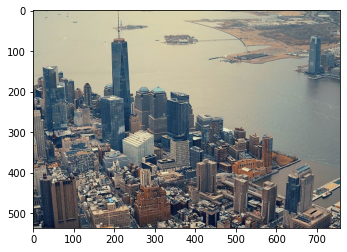

In [ ]:
plt.imshow(raw_images[1])

In [ ]:
Stitched_images = [ raw_images[0] ]

for i in range(1 , len( raw_images ) ) :
  kp1, desc1, SIFT_img1 = SIFT_detection( Stitched_images[-1] )
  kp2, desc2, SIFT_img2 = SIFT_detection( raw_images[i] )

  print(i)

  m = keyPoint_matching( desc1 , desc2 )


  m = Prune_matches( m )

  H, masked = RANSAC_homography( m, kp1 , kp2 )

  Stitched_images.append( Warp_stitching( Stitched_images[-1] , raw_images[i] , H ) )


1
2


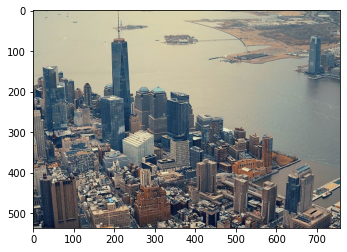

In [ ]:
plt.imshow(raw_images[1])

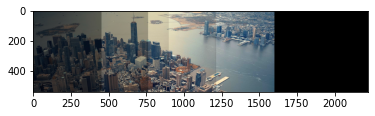

In [ ]:
plt.imshow(Stitched_images[2])

537


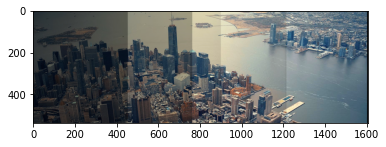

In [ ]:
plt.imshow(complete_auto_crop(Stitched_images[2]))

In [ ]:
type(desc1)

In [ ]:
plt.imshow(Stitched_images[2])

In [ ]:
'''
from PIL import Image as Pl
imms = Pl.fromarray(Stitched_images[2])
imms = imms.convert('L')
imms = np.array(imms)

entr = calc_entropy( imms )


In [ ]:
'''
plt.imshow(entr,cmap='gray')
plt.xlabel('Entropy in 10x10 neighbourhood')
#plt.colorbar()


In [ ]:
#ss = calc_seam( entr )

In [ ]:
'''
plt.imshow(entr,cmap='gray')

for col in ss :
  x_coords = []
  y_coords = []
  for row in col :
    x_coords.append( row[1] )
    y_coords.append( row[0] )
  plt.plot(x_coords,y_coords, color='red', linewidth=0.1)
'''

# Image Stitching Method 2 Main Driver

In [ ]:

Stitched_images_2 = [ raw_images[0] ]

for i in range(1 , len( raw_images ) ) :
  kp1, img1 = custom_Harris_Keypoints(Stitched_images_2[-1], 6 , 0.23, 1000)
  kp2, img2 = custom_Harris_Keypoints(raw_images[i], 6 , 0.23, 1000)

  print(len(kp1))
  print(len(kp2))

  k1, desc1 = SIFT_description_detection(Stitched_images_2[-1], kp1)
  k2, desc2 = SIFT_description_detection(raw_images[i], kp2)

  m = keyPoint_matching( desc1 , desc2 )

  m = Prune_matches( m )

  H, masked = RANSAC_homography( m, k1 , k2 )

  Stitched_images_2.append( Warp_stitching( Stitched_images_2[-1] , raw_images[i] , H ) )


43553
38512
63714
37851
